
---
# Implementation of **Value Iteration**, **Policy Iteration** and **Modified Policy Iteration(MDP)** algorithms.

The following is the MDP.py implementation from the sceleton code in A1 part 1.

---


In [16]:
import numpy as np


class MDP:
    '''A simple MDP class.  It includes the following members'''

    def __init__(self, T, R, discount):
        '''Constructor for the MDP class

        Inputs:
        T -- Transition function: |A| x |S| x |S'| array
        R -- Reward function: |A| x |S| array
        discount -- discount factor: scalar in [0,1)

        The constructor verifies that the inputs are valid and sets
        corresponding variables in a MDP object'''

        assert T.ndim == 3, "Invalid transition function: it should have 3 dimensions"
        self.nActions = T.shape[0]
        self.nStates = T.shape[1]
        assert T.shape == (
        self.nActions, self.nStates, self.nStates), "Invalid transition function: it has dimensionality " + repr(
            T.shape) + ", but it should be (nActions,nStates,nStates)"
        assert (abs(T.sum(
            2) - 1) < 1e-5).all(), "Invalid transition function: some transition probability does not equal 1"
        self.T = T
        assert R.ndim == 2, "Invalid reward function: it should have 2 dimensions"
        assert R.shape == (self.nActions, self.nStates), "Invalid reward function: it has dimensionality " + repr(
            R.shape) + ", but it should be (nActions,nStates)"
        self.R = R
        assert 0 <= discount < 1, "Invalid discount factor: it should be in [0,1)"
        self.discount = discount

    def valueIteration(self, initialV, nIterations=np.inf, tolerance=0.01):
        '''Value iteration procedure
        V <-- max_a R^a + gamma T^a V

        Inputs:
        initialV -- Initial value function: array of |S| entries
        nIterations -- limit on the # of iterations: scalar (default: infinity)
        tolerance -- threshold on ||V^n-V^n+1||_inf: scalar (default: 0.01)

        Outputs: 
        V -- Value function: array of |S| entries
        iterId -- # of iterations performed: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        V = initialV
        iterId = 0
        epsilon = np.inf
        policy = np.zeros(len(initialV), dtype=int)

        """
        print("===========================================================================")
        print("Executing Value Iteration")
        print("--------------------------------------------")
        """

        while iterId < nIterations and epsilon > tolerance:
            Ta_V = np.matmul(self.T, V)
            gamma_Ta_V = self.discount * Ta_V
            all_possible_values = self.R + gamma_Ta_V
            policy = np.argmax(all_possible_values, axis=0)  # Choose the best actions for each state, policy means keep
            V_new = np.amax((all_possible_values), axis=0)  # Choose the best action values for each state
            # np.round/np.around does not work for 0.5 so not reducing to 2 decimal places
            V_diff = (V_new - V)
            V = V_new
            epsilon = np.linalg.norm(V_diff, np.inf)
            #print("Iteration : " + str(iterId) + " V : " + str(V) + " Policy: " + str(policy) + " epsilon: " + str(epsilon))
            iterId = iterId + 1

        """
        print("--------------------------------------------")
        print("Final State values after " + str(iterId) + " iterations , V: " + str(V) + " Policy: " + str(policy))
        print("===========================================================================")
        """

        return [V, iterId, epsilon]

    def extractPolicy(self, V):
        '''Procedure to extract a policy from a value function
        pi <-- argmax_a R^a + gamma T^a V

        Inputs:
        V -- Value function: array of |S| entries

        Output:
        policy -- Policy: array of |S| entries'''

        """
        print("***************************************************************")
        print("Executing Policy Extraction")
        print("--------------------------------------------")
        """

        all_possible_values = (self.R + (self.discount*(np.matmul(self.T, V))))  # Get values for all possible state transition in this state

        """
        print("All Values for All possible state transition: ")
        print(all_possible_values)
        """

        policy = np.argmax(all_possible_values, axis=0)  # Choose the best actions for each state, policy means keep

        """
        print("Extracted Policy : " + str(policy))
        print("--------------------------------------------")
        """

        """
        # track of action chosen at timestamp t, instead of choosing only value
        max_values = [all_possible_values[policy[i]][i] for i in range(len(policy))]
        print("Values Corresponding to Selected Policies: " + str(max_values))
        print("***************************************************************")
        """

        return policy

    def evaluatePolicy(self, policy):
        '''Evaluate a policy by solving a system of linear equations
        V^pi = R^pi + gamma T^pi V^pi

        Input:
        policy -- Policy: array of |S| entries

        Ouput:
        V -- Value function: array of |S| entries'''

        """
        print("***************************************************************")
        print("Executing Policy Evaluation")
        print("--------------------------------------------")
        print("Policy : " + str(policy))
        print("Evaluating a policy by solving a system of linear equations")
        """

        R_policy = np.array([self.R[policy[i]][i] for i in range(len(policy))])
        T_policy = np.array([self.T[policy[i]][i] for i in range(len(policy))])
        gamma_T_policy = self.discount * T_policy
        assert gamma_T_policy.shape[0] == gamma_T_policy.shape[1], "gamma_T_policy matrix should be square"
        V = np.matmul(np.linalg.inv(np.identity(len(policy)) - gamma_T_policy), R_policy)

        """
        print("V : " + str(V))
        print("***************************************************************")
        """

        return V

    def policyIteration(self, initialPolicy, nIterations=np.inf):
        '''Policy iteration procedure: alternate between policy
        evaluation (solve V^pi = R^pi + gamma T^pi V^pi) and policy
        improvement (pi <-- argmax_a R^a + gamma T^a V^pi).

        Inputs:
        initialPolicy -- Initial policy: array of |S| entries
        nIterations -- limit on # of iterations: scalar (default: inf)

        Outputs: 
        policy -- Policy: array of |S| entries
        V -- Value function: array of |S| entries
        iterId -- # of iterations peformed by modified policy iteration: scalar'''

        policy = initialPolicy  # np.zeros(self.nStates)
        V = np.zeros(self.nStates)
        iterId = 0

        """
        print("===========================================================================")
        print("Executing Policy Iteration")
        print("--------------------------------------------")
        """

        while iterId < nIterations:
            V = self.evaluatePolicy(policy)
            #print("Iteration : " + str(iterId) + " V : " + str(V) + " policy : " + str(policy))

            policy_new = self.extractPolicy(V)
            iterId = iterId + 1

            if np.array_equal(policy_new, policy):
                break

            policy = policy_new

        """
        print("Iteration : " + str(iterId) + " V : " + str(V) + " policy : " + str(policy))
        print("--------------------------------------------")
        print("Final policy after " + str(iterId) + " iterations , policy: " + str(policy))
        print("===========================================================================")
        """

        return [policy, V, iterId]

    def evaluatePolicyPartially(self, policy, initialV, nIterations=np.inf, tolerance=0.01):
        '''Partial policy evaluation:
        Repeat V^pi <-- R^pi + gamma T^pi V^pi

        Inputs:
        policy -- Policy: array of |S| entries
        initialV -- Initial value function: array of |S| entries
        nIterations -- limit on the # of iterations: scalar (default: infinity)
        tolerance -- threshold on ||V^n-V^n+1||_inf: scalar (default: 0.01)

        Outputs: 
        V -- Value function: array of |S| entries
        iterId -- # of iterations performed: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        V = initialV  # np.zeros(self.nStates)
        iterId = 0
        epsilon = np.inf

        """
        print("***************************************************************")
        print("Executing Partial Policy Evaluation")
        print("--------------------------------------------")
        print("Policy : " + str(policy))
        print("Evaluating a policy by repeating " + str(nIterations) + " times.")
        print("Iteration : " + str(iterId) + " V : " + str(V) + " Policy: " + str(policy))
        """

        while iterId < nIterations and epsilon > tolerance:
            iterId = iterId+1
            R_policy = np.array([self.R[policy[i]][i] for i in range(len(policy))])
            T_policy = np.array([self.T[policy[i]][i] for i in range(len(policy))])
            Vnew = R_policy + (self.discount * np.matmul(T_policy, V))
            epsilon = np.linalg.norm((Vnew-V), np.inf)
            V = Vnew

            #print("Iteration : " + str(iterId) + " V : " + str(V) + " Policy: " + str(policy) + " epsilon : " + str(epsilon))

        """
        print("V : " + str(V))
        print("***************************************************************")
        """

        return [V, iterId, epsilon]

    def modifiedPolicyIteration(self, initialPolicy, initialV, nEvalIterations=5, nIterations=np.inf, tolerance=0.01):
        '''Modified policy iteration procedure: alternate between
        partial policy evaluation (repeat a few times V^pi <-- R^pi + gamma T^pi V^pi)
        and policy improvement (pi <-- argmax_a R^a + gamma T^a V^pi)

        Inputs:
        initialPolicy -- Initial policy: array of |S| entries
        initialV -- Initial value function: array of |S| entries
        nEvalIterations -- limit on # of iterations to be performed in each partial policy evaluation: scalar (default: 5)
        nIterations -- limit on # of iterations to be performed in modified policy iteration: scalar (default: inf)
        tolerance -- threshold on ||V^n-V^n+1||_inf: scalar (default: 0.01)

        Outputs: 
        policy -- Policy: array of |S| entries
        V -- Value function: array of |S| entries
        iterId -- # of iterations peformed by modified policy iteration: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        policy = initialPolicy
        V = initialV
        iterId = 0
        epsilon = np.inf

        """
        print("===========================================================================")
        print("Executing Modified Policy Iteration")
        print("--------------------------------------------")
        print("Iteration : " + str(iterId) + " policy : " + str(policy))
        """

        while iterId < nIterations and epsilon > tolerance:
            iterId = iterId + 1
            Vn, _ , _  = self.evaluatePolicyPartially(policy, V, nEvalIterations, tolerance)
            #print("Vn : " + str(Vn))
            all_possible_values = (self.R + (self.discount * np.matmul(self.T,Vn)))  # Get values for all possible state transition in this state
            policy = np.argmax(all_possible_values, axis=0)  # Choose the best actions for each state, policy means keep

            Vn_plus_1 = [all_possible_values[policy[i]][i] for i in range(len(policy))]
            V_diff = (Vn_plus_1 - Vn)
            V = Vn_plus_1
            epsilon = np.linalg.norm(V_diff, np.inf)
            #print("Iteration : " + str(iterId) + " policy : " + str(policy))

        """
        print("--------------------------------------------")
        print("Final policy after " + str(iterId) + " iterations , policy: " + str(policy))
        print("===========================================================================")
        """

        return [policy, V, iterId, epsilon]


## Testing value iteration, policy iteration and modified policy iteration for Markov decision processes with provided example
---

The following is the TestMDP.py file to test out the the simple MDP example from Lecture 1b Slides 17-18.

---


In [17]:
''' Construct simple MDP as described in Lecture 1b Slides 17-18'''
# Transition function: |A| x |S| x |S'| array
T = np.array([[[0.5,0.5,0,0],[0,1,0,0],[0.5,0.5,0,0],[0,1,0,0]],[[1,0,0,0],[0.5,0,0,0.5],[0.5,0,0.5,0],[0,0,0.5,0.5]]])
# Reward function: |A| x |S| array
R = np.array([[0,0,10,10],[0,0,10,10]])
# Discount factor: scalar in [0,1)
discount = 0.9        
# MDP object
mdp = MDP(T,R,discount)


---

Testing valueIteration & extractPolicy procedure using simple MDP example from Lecture 1b Slides 17-18.

---


In [18]:
'''Test each procedure'''
[V,nIterations,epsilon] = mdp.valueIteration(initialV=np.zeros(mdp.nStates))
policy = mdp.extractPolicy(V)
print("V : " + str(V))
print("nIterations : " + str(nIterations))
print("Policy : " + str(policy))

V : [31.49636306 38.51527513 43.935435   54.1128575 ]
nIterations : 58
Policy : [0 1 1 1]



---


Testing evaluatePolicy procedure using simple MDP example from Lecture 1b Slides 17-18. We see the results from evaluatePolicy match from the previous valueIteration and extractPolicy procedures

---


In [19]:
V = mdp.evaluatePolicy(np.array([1,0,1,0]))
print("Value corresponding to policy [1,0,1,0]: " + str(V))

V = mdp.evaluatePolicy(np.array([0,1,1,1]))
print("Value corresponding to policy [0,1,1,1]: " + str(V))

Value corresponding to policy [1,0,1,0]: [ 0.          0.         18.18181818 10.        ]
Value corresponding to policy [0,1,1,1]: [31.58510431 38.60401638 44.02417625 54.20159875]



---

Testing policyIteration procedure using simple MDP example from Lecture 1b Slides 17-18. We see that the policy result and value results match the valueIteration procedure.

---


In [20]:
[policy,V,iterId] = mdp.policyIteration(np.array([0,0,0,0]))
print("V : " + str(V))
print("nIterations : " + str(iterId))
print("Epsilon : " + str(policy))

V : [31.58510431 38.60401638 44.02417625 54.20159875]
nIterations : 2
Epsilon : [0 1 1 1]



---

Testing modifiedPolicyIteration(MDP) procedure using simple MDP example from Lecture 1b Slides 17-18. We see that the policy result and value results match the valueIteration procedure.

---



In [21]:
[V,iterId,epsilon] = mdp.evaluatePolicyPartially(np.array([1,0,1,0]),np.array([0,10,0,13]))
[policy,V,iterId,tolerance] = mdp.modifiedPolicyIteration(np.array([1,0,1,0]),np.array([0,10,0,13]))
print("V : " + str(V))
print("nIterations : " + str(iterId))
print("Policy : " + str(policy))

V : [31.50605365934906, 38.524965727978426, 43.945125603197766, 54.12254810271034]
nIterations : 11
Policy : [0 1 1 1]




---

## **Maze Problem** solving using value iteration, policy iteration and modified policy iteration.

---


In [22]:
import numpy as np

''' Construct a simple maze MDP

  Grid world layout:

  ---------------------
  |  0 |  1 |  2 |  3 |
  ---------------------
  |  4 |  5 |  6 |  7 |
  ---------------------
  |  8 |  9 | 10 | 11 |
  ---------------------
  | 12 | 13 | 14 | 15 |
  ---------------------

  Goal state: 14 
  Bad state: 9
  End state: 16

  The end state is an absorbing state that the agent transitions 
  to after visiting the goal state.

  There are 17 states in total (including the end state) 
  and 4 actions (up, down, left, right).'''

# Transition function: |A| x |S| x |S'| array
T = np.zeros([4, 17, 17])
a = 0.7;  # intended move
b = 0.15;  # lateral move

# up (a = 0)

T[0, 0, 0] = a + b;
T[0, 0, 1] = b;

T[0, 1, 0] = b;
T[0, 1, 1] = a;
T[0, 1, 2] = b;

T[0, 2, 1] = b;
T[0, 2, 2] = a;
T[0, 2, 3] = b;

T[0, 3, 2] = b;
T[0, 3, 3] = a + b;

T[0, 4, 4] = b;
T[0, 4, 0] = a;
T[0, 4, 5] = b;

T[0, 5, 4] = b;
T[0, 5, 1] = a;
T[0, 5, 6] = b;

T[0, 6, 5] = b;
T[0, 6, 2] = a;
T[0, 6, 7] = b;

T[0, 7, 6] = b;
T[0, 7, 3] = a;
T[0, 7, 7] = b;

T[0, 8, 8] = b;
T[0, 8, 4] = a;
T[0, 8, 9] = b;

T[0, 9, 8] = b;
T[0, 9, 5] = a;
T[0, 9, 10] = b;

T[0, 10, 9] = b;
T[0, 10, 6] = a;
T[0, 10, 11] = b;

T[0, 11, 10] = b;
T[0, 11, 7] = a;
T[0, 11, 11] = b;

T[0, 12, 12] = b;
T[0, 12, 8] = a;
T[0, 12, 13] = b;

T[0, 13, 12] = b;
T[0, 13, 9] = a;
T[0, 13, 14] = b;

T[0, 14, 16] = 1;

T[0, 15, 11] = a;
T[0, 15, 14] = b;
T[0, 15, 15] = b;

T[0, 16, 16] = 1;

# down (a = 1)

T[1, 0, 0] = b;
T[1, 0, 4] = a;
T[1, 0, 1] = b;

T[1, 1, 0] = b;
T[1, 1, 5] = a;
T[1, 1, 2] = b;

T[1, 2, 1] = b;
T[1, 2, 6] = a;
T[1, 2, 3] = b;

T[1, 3, 2] = b;
T[1, 3, 7] = a;
T[1, 3, 3] = b;

T[1, 4, 4] = b;
T[1, 4, 8] = a;
T[1, 4, 5] = b;

T[1, 5, 4] = b;
T[1, 5, 9] = a;
T[1, 5, 6] = b;

T[1, 6, 5] = b;
T[1, 6, 10] = a;
T[1, 6, 7] = b;

T[1, 7, 6] = b;
T[1, 7, 11] = a;
T[1, 7, 7] = b;

T[1, 8, 8] = b;
T[1, 8, 12] = a;
T[1, 8, 9] = b;

T[1, 9, 8] = b;
T[1, 9, 13] = a;
T[1, 9, 10] = b;

T[1, 10, 9] = b;
T[1, 10, 14] = a;
T[1, 10, 11] = b;

T[1, 11, 10] = b;
T[1, 11, 15] = a;
T[1, 11, 11] = b;

T[1, 12, 12] = a + b;
T[1, 12, 13] = b;

T[1, 13, 12] = b;
T[1, 13, 13] = a;
T[1, 13, 14] = b;

T[1, 14, 16] = 1;

T[1, 15, 14] = b;
T[1, 15, 15] = a + b;

T[1, 16, 16] = 1;

# left (a = 2)

T[2, 0, 0] = a + b;
T[2, 0, 4] = b;

T[2, 1, 1] = b;
T[2, 1, 0] = a;
T[2, 1, 5] = b;

T[2, 2, 2] = b;
T[2, 2, 1] = a;
T[2, 2, 6] = b;

T[2, 3, 3] = b;
T[2, 3, 2] = a;
T[2, 3, 7] = b;

T[2, 4, 0] = b;
T[2, 4, 4] = a;
T[2, 4, 8] = b;

T[2, 5, 1] = b;
T[2, 5, 4] = a;
T[2, 5, 9] = b;

T[2, 6, 2] = b;
T[2, 6, 5] = a;
T[2, 6, 10] = b;

T[2, 7, 3] = b;
T[2, 7, 6] = a;
T[2, 7, 11] = b;

T[2, 8, 4] = b;
T[2, 8, 8] = a;
T[2, 8, 12] = b;

T[2, 9, 5] = b;
T[2, 9, 8] = a;
T[2, 9, 13] = b;

T[2, 10, 6] = b;
T[2, 10, 9] = a;
T[2, 10, 14] = b;

T[2, 11, 7] = b;
T[2, 11, 10] = a;
T[2, 11, 15] = b;

T[2, 12, 8] = b;
T[2, 12, 12] = a + b;

T[2, 13, 9] = b;
T[2, 13, 12] = a;
T[2, 13, 13] = b;

T[2, 14, 16] = 1;

T[2, 15, 11] = b;
T[2, 15, 14] = a;
T[2, 15, 15] = b;

T[2, 16, 16] = 1;

# right (a = 3)

T[3, 0, 0] = b;
T[3, 0, 1] = a;
T[3, 0, 4] = b;

T[3, 1, 1] = b;
T[3, 1, 2] = a;
T[3, 1, 5] = b;

T[3, 2, 2] = b;
T[3, 2, 3] = a;
T[3, 2, 6] = b;

T[3, 3, 3] = a + b;
T[3, 3, 7] = b;

T[3, 4, 0] = b;
T[3, 4, 5] = a;
T[3, 4, 8] = b;

T[3, 5, 1] = b;
T[3, 5, 6] = a;
T[3, 5, 9] = b;

T[3, 6, 2] = b;
T[3, 6, 7] = a;
T[3, 6, 10] = b;

T[3, 7, 3] = b;
T[3, 7, 7] = a;
T[3, 7, 11] = b;

T[3, 8, 4] = b;
T[3, 8, 9] = a;
T[3, 8, 12] = b;

T[3, 9, 5] = b;
T[3, 9, 10] = a;
T[3, 9, 13] = b;

T[3, 10, 6] = b;
T[3, 10, 11] = a;
T[3, 10, 14] = b;

T[3, 11, 7] = b;
T[3, 11, 11] = a;
T[3, 11, 15] = b;

T[3, 12, 8] = b;
T[3, 12, 13] = a;
T[3, 12, 12] = b;

T[3, 13, 9] = b;
T[3, 13, 14] = a;
T[3, 13, 13] = b;

T[3, 14, 16] = 1;

T[3, 15, 11] = b;
T[3, 15, 15] = a + b;

T[3, 16, 16] = 1;

# Reward function: |A| x |S| array
R = -1 * np.ones([4, 17]);

# set rewards
R[:, 14] = 100;  # goal state
R[:, 9] = -70;  # bad state
R[:, 16] = 0;  # end state

# Discount factor: scalar in [0,1)
discount = 0.95

# MDP object
mdp = MDP(T, R, discount)




---

## Part I.I: Calculating **policy**, **value function** and **number of iterations** needed by **value iteration** in Maze Problem

---
### Testing Parameters

*   Tolerance : 0.01. Used following line in *mdp.valueIteration* procedure
```
#  tolerance=0.01
```
*   Initial Value Function: Zero for all states. Used following line in *mdp.valueIteration* procedure
```
#  initialV=np.zeros(mdp.nStates)
```

---

### Results

1.   **Policy** : [3 3 1 1 3 0 1 1 1 3 3 1 3 3 0 2 0]
2.   **Value Function** : [ 49.66895295  55.27161487  61.57363146  65.87460207  48.00953133 52.30188839  68.13923599  73.25481858  50.22617115  -0.42481753
  77.06611566  81.36344171  66.36179067  76.31383816 100.
  89.90583635   0.        ]
3.   **Number of Iterations** : 26

--- 


In [23]:
[V, nIterations, epsilon] = mdp.valueIteration(initialV=np.zeros(mdp.nStates), tolerance=0.01)
policy = mdp.extractPolicy(V)

In [24]:
print("==================================================================")
print("MDPMaze Value Iteration:")
print("Policy " + str(policy))
print("Value Function: " + str(V))
print("Number of Iterations: " + str(nIterations))
print("==================================================================\n\n")


MDPMaze Value Iteration:
Policy [3 3 1 1 3 0 1 1 1 3 3 1 3 3 0 2 0]
Value Function: [ 49.66895295  55.27161487  61.57363146  65.87460207  48.00953133
  52.30188839  68.13923599  73.25481858  50.22617115  -0.42481753
  77.06611566  81.36344171  66.36179067  76.31383816 100.
  89.90583635   0.        ]
Number of Iterations: 26





---

## Part I.II: Calculating **policy**, **value function** and **number of iterations** needed by **policy iteration** in Maze Problem

---

### Testing Parameters

*   Initial Policy: Uses action 0 in all states. Used following line in *mdp.policyIteration* procedure
```
#  initialPolicy = np.zeros(mdp.nStates, dtype=int)
```

---

### Results


1.   **Policy** : [3 3 1 1 3 0 1 1 1 3 3 1 3 3 0 2 0]
2.   **Value Function** : [ 49.69078867  55.28617892  61.58230087  65.87897994  48.03187576  52.32047965  68.1447605   73.25676304  50.23031164  -0.41942079
  77.06767431  81.36397885  66.36430029  76.31513999 100.
  89.90596733   0.        ]
3.   **Number of Iterations** : 7

---



In [25]:
[policy, V, nIterations] = mdp.policyIteration(initialPolicy = np.zeros(mdp.nStates, dtype=int))


In [26]:
print("==================================================================")
print("MDPMaze policy Iteration:")
print("Policy " + str(policy))
print("Value Function: " + str(V))
print("Number of Iterations: " + str(nIterations))
print("==================================================================\n\n")

MDPMaze policy Iteration:
Policy [3 3 1 1 3 0 1 1 1 3 3 1 3 3 0 2 0]
Value Function: [ 49.69078867  55.28617892  61.58230087  65.87897994  48.03187576
  52.32047965  68.1447605   73.25676304  50.23031164  -0.41942079
  77.06767431  81.36397885  66.36430029  76.31513999 100.
  89.90596733   0.        ]
Number of Iterations: 7





---

## Part I.III: Calculating **number of iterations** to converge when varying number of iterations in partial policy evaluation from 1 to 10 in Maze Problem

---

### Testing Parameters

*   Tolerance : 0.01 . Used following line in *mdp.modifiedPolicyIteration* procedure
```
#  tolerance=0.01
```
*   Initial Policy : Uses action 0 in all states . Used following line in *mdp.modifiedPolicyIteration* procedure
```
#  initialPolicy = np.zeros(mdp.nStates, dtype=int)
```
*   Initial Value Function : Assigned 0 to in all states . Used following line in *mdp.modifiedPolicyIteration* procedure
```
#  initialPolicy = initialV = np.zeros(mdp.nStates)
```
*   Number of iterations in Partial Policy Evaluation : 0 to 10
---

### Results

| Number of Iterations in Partial Policy Evaluation | Number of Iterations for Convergence |
| --- | --- | 
| 1 | 14 | 
| 2 | 10 | 
| 3 | 8 | 
| 4 | 8 | 
| 5 | 7 | 
| 6 | 7 | 
| 7 | 7 | 
| 8 | 6 | 
| 9 | 7 | 
| 10 | 7 | 


---


In [27]:

print("==================================================================")
print("MDPMaze Modifier Policy Iteration:")
for nIterPPE in range(1, 11):
    [policy, V, nIterations, epsilon] = mdp.modifiedPolicyIteration(initialPolicy = np.zeros(mdp.nStates, dtype=int),
                                                                    initialV = np.zeros(mdp.nStates), nEvalIterations=nIterPPE,
                                                                    tolerance=0.01)
    print("# of Iterations in Partial Policy Evaluation: " + str(nIterPPE) + " , # of Iterations for Convergence: " + str(nIterations))
print("==================================================================\n\n")


MDPMaze Modifier Policy Iteration:
# of Iterations in Partial Policy Evaluation: 1 , # of Iterations for Convergence: 14
# of Iterations in Partial Policy Evaluation: 2 , # of Iterations for Convergence: 10
# of Iterations in Partial Policy Evaluation: 3 , # of Iterations for Convergence: 8
# of Iterations in Partial Policy Evaluation: 4 , # of Iterations for Convergence: 8
# of Iterations in Partial Policy Evaluation: 5 , # of Iterations for Convergence: 7
# of Iterations in Partial Policy Evaluation: 6 , # of Iterations for Convergence: 7
# of Iterations in Partial Policy Evaluation: 7 , # of Iterations for Convergence: 7
# of Iterations in Partial Policy Evaluation: 8 , # of Iterations for Convergence: 6
# of Iterations in Partial Policy Evaluation: 9 , # of Iterations for Convergence: 7
# of Iterations in Partial Policy Evaluation: 10 , # of Iterations for Convergence: 7




---
## Part I.IV: Discussion
---
| Convergence Iterations in Value Iteration | Convergence Iterations in Policy Iteration | Convergence Iterations in Partial Policy Iteration | 
| --- | --- | --- | 
| 26 | 7 | 6 (For 8 iterations in partial policy evaluation) | 

In the maze problem, there are a total of |S| = 17 states and |A| = 4 actions. For MDP problem, we see that a k=8 value produces the least number of iterations (6) for convergence for given range of k values (1 to 10). **To recap, k denotes the number of iterations in partial policy evaluation step for MDP.**

Increases the number of iterations in partial policy evaluation results in slowly decreasing the number of iterations in MDP for convergence.

As number of Actions |A| (= 4) < number of states |S| (=17), runtime for each iteration in 
*   **Value Iteration** reduces to O(|S|<sup>2</sup>|A|)
*   **Policy Iteration** reduces to O(|S|<sup>3</sup>) 
[As |S| > |A|, |S|<sup>3</sup> > |S|<sup>2</sup>|A| and O(|S|<sup>3</sup> + |S|<sup>2</sup>|A|) reduces to O(|S|<sup>3</sup>)]  
*   **MDP** reduces to O(k|S|<sup>2</sup>) when k > |A| (number of partial policy evaluation >= 5) and  O(|S|<sup>2</sup>|A|) when k <= |A| (number of partial policy evaluation is between 1 to 4 inclusive)

For **k > 4**, each iteration in MDP will be less complex than policy iteration (k|S|<sup>2</sup> < |S|<sup>2</sup>) until k > |S|, or number of iterations in partial policy evaluation crosses 17. However, between 4 < k < 17, each iteration in MDP will still be more complex than value iteration. 

For **k <= 4**, each iteration in MDP will be less complex than policy iteration [O(k|S|<sup>2</sup>) < O(|S|<sup>2</sup>)] and value iteration [O(k|S|<sup>2</sup>) < O(|S|<sup>2</sup>|A|)]. 




---

# Part II: Q-Learning Algorithm

---



---



In [28]:
import numpy as np
import matplotlib.pyplot as plt

class RL:
    def __init__(self, mdp, sampleReward):
        '''Constructor for the RL class

        Inputs:
        mdp -- Markov decision process (T, R, discount)
        sampleReward -- Function to sample rewards (e.g., bernoulli, Gaussian).
        This function takes one argument: the mean of the distributon and 
        returns a sample from the distribution.
        '''

        self.mdp = mdp
        self.sampleReward = sampleReward

    def sampleRewardAndNextState(self, state, action):
        '''Procedure to sample a reward and the next state
        reward ~ Pr(r)
        nextState ~ Pr(s'|s,a)

        Inputs:
        state -- current state
        action -- action to be executed

        Outputs: 
        reward -- sampled reward
        nextState -- sampled next state
        '''

        reward = self.sampleReward(self.mdp.R[action, state])
        cumProb = np.cumsum(self.mdp.T[action, state, :])
        nextState = np.where(cumProb >= np.random.rand(1))[0][0]
        return [reward, nextState]

    def qLearning(self, s0, initialQ, nEpisodes, nSteps, epsilon=0, temperature=0.0):
        '''qLearning algorithm.  
        When epsilon > 0: perform epsilon exploration (i.e., with probability epsilon, select action at random )
        When epsilon == 0 and temperature > 0: perform Boltzmann exploration with temperature parameter
        When epsilon == 0 and temperature == 0: no exploration (i.e., selection action with best Q-value)

        Inputs:
        s0 -- initial state
        initialQ -- initial Q function (|A|x|S| array)
        nEpisodes -- # of episodes (one episode consists of a trajectory of nSteps that starts in s0
        nSteps -- # of steps per episode
        epsilon -- probability with which an action is chosen at random
        temperature -- parameter that regulates Boltzmann exploration

        Outputs: 
        Q -- final Q function (|A|x|S| array)
        policy -- final policy
        '''


        TRIAL = 100
        avg_cumulative_rewards = np.zeros(nEpisodes)

        Q = initialQ
        policy = np.zeros(self.mdp.nStates, int)

        for trial in range(TRIAL):
            Q = initialQ
            #policy = np.zeros(self.mdp.nStates, int)

            cumulative_rewards = np.zeros(nEpisodes)

            for episode in range(nEpisodes):
                
                s = s0  # Starting each episode at s0 according to specifications
                policy = np.zeros(self.mdp.nStates, int)
                counterStateActionPair = np.zeros((self.mdp.nActions, self.mdp.nStates), dtype=np.int)

                for t in range(nSteps):

                    a = np.argmax(Q, axis=0)[s]  # Choosing the best action a* = argmax_a Q(s,a)

                    if epsilon > 0:
                        # perform epsilon exploration (i.e., with probability epsilon, select action at random )
                        #print("Epsilon Greedy Policy")
                        currentProbValue = np.random.random_sample()

                        if currentProbValue <= epsilon:
                            #print("Executing Random Action")
                            a = np.random.randint(self.mdp.nActions)

                    else:
                        if temperature > 0:
                            # perform Boltzmann exploration with temperature parameter
                            #print("Boltzman Exploration Policy")
                            all_a = Q[:, s] / temperature
                            pr_all_a = (np.exp(all_a) / np.sum(np.exp(all_a)))

                            a = 0
                            currentProbValue = np.random.random_sample()
                            currentPrSum = 0.0
                            while a < (len(pr_all_a)-1):
                                currentPrSum += pr_all_a[a]
                                if currentProbValue <= currentPrSum:
                                    break

                                a += 1


                    #   End of Action selection


                    # Execute a
                    [reward, nextState] = self.sampleRewardAndNextState(s, a)                    
                    
                    counterStateActionPair[a][s] += 1
                    learningRate = (1.0 / counterStateActionPair[a][s])
                    
                    Q[a][s] = Q[a][s] + (learningRate * (reward
                                                         + (self.mdp.discount * np.amax(Q[:, nextState]))
                                                         - Q[a][s]
                                                         )
                                         )
                    cumulative_rewards[episode] += (np.power(self.mdp.discount, t) * reward)
                    policy[s] = a
                    s = nextState

                """
                print("Q : " + str(Q))
                print("Policy : " + str(policy))
                print("\n")
                """

            #print("Cumulative Rewards : " + str(cumulative_rewards))

            avg_cumulative_rewards += cumulative_rewards

        avg_cumulative_rewards = avg_cumulative_rewards / TRIAL

        xAxis = range(1, (len(avg_cumulative_rewards)+1))
        yAxis = avg_cumulative_rewards
        pltLabel = "Epsilon : " + str(epsilon) + "\nTemp : " + str(temperature)
        plt.plot(xAxis, yAxis, label= pltLabel)


        return [Q, policy]


In [29]:
import numpy as np
import matplotlib.pyplot as plt

''' Construct a simple maze MDP

  Grid world layout:

  ---------------------
  |  0 |  1 |  2 |  3 |
  ---------------------
  |  4 |  5 |  6 |  7 |
  ---------------------
  |  8 |  9 | 10 | 11 |
  ---------------------
  | 12 | 13 | 14 | 15 |
  ---------------------

  Goal state: 14 
  Bad state: 9
  End state: 16

  The end state is an absorbing state that the agent transitions 
  to after visiting the goal state.

  There are 17 states in total (including the end state) 
  and 4 actions (up, down, left, right).'''

# Transition function: |A| x |S| x |S'| array
T = np.zeros([4,17,17])
a = 0.7;  # intended move
b = 0.15;  # lateral move

# up (a = 0)

T[0,0,0] = a+b;
T[0,0,1] = b;

T[0,1,0] = b;
T[0,1,1] = a;
T[0,1,2] = b;

T[0,2,1] = b;
T[0,2,2] = a;
T[0,2,3] = b;

T[0,3,2] = b;
T[0,3,3] = a+b;

T[0,4,4] = b;
T[0,4,0] = a;
T[0,4,5] = b;

T[0,5,4] = b;
T[0,5,1] = a;
T[0,5,6] = b;

T[0,6,5] = b;
T[0,6,2] = a;
T[0,6,7] = b;

T[0,7,6] = b;
T[0,7,3] = a;
T[0,7,7] = b;

T[0,8,8] = b;
T[0,8,4] = a;
T[0,8,9] = b;

T[0,9,8] = b;
T[0,9,5] = a;
T[0,9,10] = b;

T[0,10,9] = b;
T[0,10,6] = a;
T[0,10,11] = b;

T[0,11,10] = b;
T[0,11,7] = a;
T[0,11,11] = b;

T[0,12,12] = b;
T[0,12,8] = a;
T[0,12,13] = b;

T[0,13,12] = b;
T[0,13,9] = a;
T[0,13,14] = b;

T[0,14,16] = 1;

T[0,15,11] = a;
T[0,15,14] = b;
T[0,15,15] = b;

T[0,16,16] = 1;

# down (a = 1)

T[1,0,0] = b;
T[1,0,4] = a;
T[1,0,1] = b;

T[1,1,0] = b;
T[1,1,5] = a;
T[1,1,2] = b;

T[1,2,1] = b;
T[1,2,6] = a;
T[1,2,3] = b;

T[1,3,2] = b;
T[1,3,7] = a;
T[1,3,3] = b;

T[1,4,4] = b;
T[1,4,8] = a;
T[1,4,5] = b;

T[1,5,4] = b;
T[1,5,9] = a;
T[1,5,6] = b;

T[1,6,5] = b;
T[1,6,10] = a;
T[1,6,7] = b;

T[1,7,6] = b;
T[1,7,11] = a;
T[1,7,7] = b;

T[1,8,8] = b;
T[1,8,12] = a;
T[1,8,9] = b;

T[1,9,8] = b;
T[1,9,13] = a;
T[1,9,10] = b;

T[1,10,9] = b;
T[1,10,14] = a;
T[1,10,11] = b;

T[1,11,10] = b;
T[1,11,15] = a;
T[1,11,11] = b;

T[1,12,12] = a+b;
T[1,12,13] = b;

T[1,13,12] = b;
T[1,13,13] = a;
T[1,13,14] = b;

T[1,14,16] = 1;

T[1,15,14] = b;
T[1,15,15] = a+b;

T[1,16,16] = 1;

# left (a = 2)

T[2,0,0] = a+b;
T[2,0,4] = b;

T[2,1,1] = b;
T[2,1,0] = a;
T[2,1,5] = b;

T[2,2,2] = b;
T[2,2,1] = a;
T[2,2,6] = b;

T[2,3,3] = b;
T[2,3,2] = a;
T[2,3,7] = b;

T[2,4,0] = b;
T[2,4,4] = a;
T[2,4,8] = b;

T[2,5,1] = b;
T[2,5,4] = a;
T[2,5,9] = b;

T[2,6,2] = b;
T[2,6,5] = a;
T[2,6,10] = b;

T[2,7,3] = b;
T[2,7,6] = a;
T[2,7,11] = b;

T[2,8,4] = b;
T[2,8,8] = a;
T[2,8,12] = b;

T[2,9,5] = b;
T[2,9,8] = a;
T[2,9,13] = b;

T[2,10,6] = b;
T[2,10,9] = a;
T[2,10,14] = b;

T[2,11,7] = b;
T[2,11,10] = a;
T[2,11,15] = b;

T[2,12,8] = b;
T[2,12,12] = a+b;

T[2,13,9] = b;
T[2,13,12] = a;
T[2,13,13] = b;

T[2,14,16] = 1;

T[2,15,11] = b;
T[2,15,14] = a;
T[2,15,15] = b;

T[2,16,16] = 1;

# right (a = 3)

T[3,0,0] = b;
T[3,0,1] = a;
T[3,0,4] = b;

T[3,1,1] = b;
T[3,1,2] = a;
T[3,1,5] = b;

T[3,2,2] = b;
T[3,2,3] = a;
T[3,2,6] = b;

T[3,3,3] = a+b;
T[3,3,7] = b;

T[3,4,0] = b;
T[3,4,5] = a;
T[3,4,8] = b;

T[3,5,1] = b;
T[3,5,6] = a;
T[3,5,9] = b;

T[3,6,2] = b;
T[3,6,7] = a;
T[3,6,10] = b;

T[3,7,3] = b;
T[3,7,7] = a;
T[3,7,11] = b;

T[3,8,4] = b;
T[3,8,9] = a;
T[3,8,12] = b;

T[3,9,5] = b;
T[3,9,10] = a;
T[3,9,13] = b;

T[3,10,6] = b;
T[3,10,11] = a;
T[3,10,14] = b;

T[3,11,7] = b;
T[3,11,11] = a;
T[3,11,15] = b;

T[3,12,8] = b;
T[3,12,13] = a;
T[3,12,12] = b;

T[3,13,9] = b;
T[3,13,14] = a;
T[3,13,13] = b;

T[3,14,16] = 1;

T[3,15,11] = b;
T[3,15,15] = a+b;

T[3,16,16] = 1;

# Reward function: |A| x |S| array
R = -1 * np.ones([4,17]);

# set rewards
R[:,14] = 100;  # goal state
R[:,9] = -70;   # bad state
R[:,16] = 0;    # end state

# Discount factor: scalar in [0,1)
discount = 0.95
        
# MDP object
mdp = MDP(T,R,discount)

# RL problem
rlProblem = RL(mdp,np.random.normal)


---
## Part II.I: Q-Learning Algorithm - Average Cumulative Discounted rewards per episode for different exploration probabilities. 
---
The execution results below show Graph 1, containing three curves corresponding to exploration probabilies ϵ = 0.1, 0.3 and 0.5. Graph 1 uses ϵ-greedy algorithm to choose a random action with probablity ϵ, otherwise it executes best action.   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epsilon : 0.1
Q : [[ 43.42844085  47.83265708  49.79529834  52.80880991  41.27698486
   46.80649468  46.35013687  60.25126318 -12.48953306 -39.75913092
    7.8208911   71.15005211  35.03706424 -13.37209162 103.16292805
   85.98819253   4.31661223]
 [ 44.35259655  41.16312649  48.96397693  81.93487184  39.46388762
  -26.22640862  70.94317797  78.57454474 -19.07918312  10.35191416
    4.04112471  91.90294922  55.86291594 101.14629478 103.4047383
   87.43142377   4.7200506 ]
 [ 43.95684953  40.71106688  45.35792463  54.28872348  42.83421094
   29.03488953  46.7445823   56.64018887  38.0143134  -30.59635201
    8.61957585  67.71492072  34.18478541  72.04847681 100.60287157
   99.76996625   3.77275679]
 [ 42.09394288  48.84704154  55.14403456  52.7815591   46.46675225
   74.21705786  72.62374056  56.02046837   8.53245547 -37.4548348
   88.36313382  73.50041456  69.88655085  57.16858368 104.44539891
   78.55510222   4.24059367]]
Policy : [1 0 0 0 3 3 3 1 0 0 0 1 0 0 3 2 1]




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epsilon : 0.3
Q : [[ 48.86461148  46.30795569  51.71529514  52.21191219  49.29494452
   57.83247074  57.22101468  58.39852759  49.31666861 -16.28849492
   60.85442197  66.66905399  52.45302444  24.55032659 105.71320485
   76.00821589   6.65621843]
 [ 51.98864867  55.39396311  49.51044266  59.03213324  46.34516874
    7.15388886  76.84842197  59.01795361  21.77053479  -6.79633582
   24.74914264  88.0839645   54.09698853  90.86348014 106.9676375
   79.7724517    6.78023755]
 [ 47.5600525   55.20790059  51.8423939   54.8148399   50.45793346
   49.71708327  56.50317716  72.09242869  47.82504057 -15.20471154
    1.52104709  67.0252185   53.40852952  61.54797212 106.29226232
  102.25977294   6.28953883]
 [ 44.55212948  49.75968406  50.86000925  52.85627726  52.39174696
   52.41925551  62.22953993  60.00557237   2.19368594  11.60939917
  100.79680091  95.2806467   96.86400813  25.1075452  107.53791569
   88.94005949   6.79554428]]
Policy : [1 0 0 0 3 1 0 0 0 3 0 0 0 1 2 0 3]




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epsilon : 0.5
Q : [[ 60.31307799  64.1068052   69.70606787  69.46149248  64.60101456
   70.80090542  74.16506409  72.15133407  38.78609422 -17.16558917
   81.94652154  80.75716299  88.70563825  23.51508015 105.09625664
   80.44244353   8.41496432]
 [ 57.58981797  64.16427278  70.71545194  68.36387418  72.36684199
   -2.72381987  97.44977865  69.51517413  90.37441299  26.84361412
  102.56347469  95.5333693   88.05856617  54.97154461 105.28857403
   83.25147784   8.31657251]
 [ 65.90216695  64.3067476   69.14134285  69.28890096  60.27821985
   47.77929776  55.92088621  70.91839129  48.31962498  15.484414
   23.48528686  75.32819951  57.16352095  58.40102502 105.68665707
  100.74560522   8.03852776]
 [ 67.79682082  69.89050268  69.5573721   70.51214908  61.90817265
   58.94082692  79.02244991  70.88789228  67.9654594  -19.0503514
   78.40821827  79.33019709  89.49778571 103.26272137 107.02059401
   82.53438314   8.74611543]]
Policy : [3 1 1 0 0 0 1 2 3 2 0 1 0 0 3 2 3]




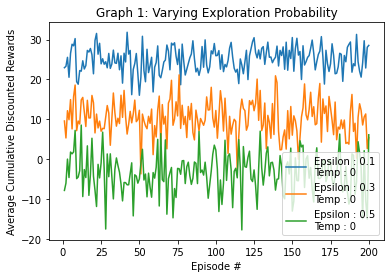

<Figure size 432x288 with 0 Axes>

In [30]:
# Graph 1
fig = plt.figure()
plt.title("Graph 1: Varying Exploration Probability")
plt.xlabel("Episode #")
plt.ylabel("Average Cumulative Discounted Rewards")
[Q,policy] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0.1,temperature=0)
print("Epsilon : 0.1")
print("Q : " + str(Q))
print("Policy : " + str(policy))
print("\n")
[Q,policy] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0.3,temperature=0)
print("Epsilon : 0.3")
print("Q : " + str(Q))
print("Policy : " + str(policy))
print("\n")
[Q,policy] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0.5,temperature=0)
print("Epsilon : 0.5")
print("Q : " + str(Q))
print("Policy : " + str(policy))
print("\n")
plt.legend(loc='best')
plt.savefig('TestRLmaze_Graph1.png', bbox_inches='tight')
plt.show()
plt.close()
plt.cla()
plt.clf()


---
## Part II.II: Q-Learning Algorithm - Average Cumulative Discounted rewards per episode for different Boltzmann Exploration Temperature. 
---
The execution results below show Graph 2, containing three curves corresponding to Boltzmann Exploration Temperatures T = 0, 10 and 20. Graph 1 uses boltzmann exploration temperature to choose an action with associated boltzman probability.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Temperature : 0
Q : [[ -9.94478795 -11.06368349  24.09818623  -7.50533793  -8.54939225
   16.97496412  21.23383363  -6.81337682 -36.48516243 -73.08152605
  -21.40927047  -2.06556605  -7.28219303 -25.29339241  98.67737193
   93.0576885   -7.36948057]
 [ 27.87777079 -13.63218698  -5.96518629  -6.08208517  30.13019846
  -64.73278641  -5.69948038  20.48743627 -12.0639646  -73.59251791
  -66.81486163  44.29569618  -7.50786499  70.24712951   0.
    0.          -7.92109463]
 [ -8.68311511  15.8555067   -6.25472158  -6.36624026  -9.09930676
  -33.87184904  -6.87771103  -5.73698381  35.18726041 -73.91438014
  -25.33254732  -1.87062576  -7.79721831 -69.22791125   0.
    0.          -7.33422356]
 [ -8.25650436 -11.09925468  -5.41543645  29.47046774  -9.04556283
  -54.86322421  -5.64991525  -4.97914989 -26.14557172   6.70531126
   41.92440265  -1.68429535  56.54234872 -64.50171934   0.
    0.           0.46158542]]
Policy : [1 0 0 0 1 0 0 0 2 0 0 0 3 1 0 0 3]




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Temperature : 10
Q : [[ 57.31746279  56.45421689  70.57824022  71.55315935  55.84271148
   54.58224053  72.33017207  82.64156963  -9.15407696 -10.3173486
  -43.16728525  87.37441776  39.2682596  -67.64149957   0.
  103.70948211   9.41959348]
 [ 57.92434323  64.37626637  80.92503865  82.65125211  36.12189033
   -9.84625573  81.81784481  87.66610627  56.56056529  -9.53171641
  -37.59313578  98.89513223  53.13760005  59.81027067   0.
   94.914773     9.29582306]
 [ 55.70850624  55.54378451  61.92542467  72.36647544  57.21434947
  -14.1520763   46.13806227  77.73320357  39.10243201 -33.77489627
  -24.97096895  83.85494331  38.78363232 -12.22128012 108.42971819
  101.91306677   9.57964085]
 [ 64.35920471  68.14772525  80.56642894  70.04478063  55.65823688
  -28.18202898  75.87039144  77.79672709 -68.19522381  15.21789019
   91.55911195  85.35307357  59.15852438 -65.79028885   0.
   -0.2654183    9.65724575]]
Policy : [3 3 3 1 0 0 0 1 0 0 0 1 0 0 2 2 0]




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Temperature : 20
Q : [[ 65.48383995  68.26905691  67.57475089  69.08055359  65.49100915
   65.34763964  68.40648875  72.87767699  72.52238727 -13.29780584
   78.79187328  76.15228652  74.04988472 103.41894944 111.45786447
   89.83515017  10.90385993]
 [ 67.46256034  66.32005749  72.11303616  69.85562802  71.85660978
   -9.69857104  76.18192963  75.50264104  81.07201192  16.37701236
    3.72742059  99.43325241  79.70169936  79.26727602 109.88861526
   98.03759803  10.31138252]
 [ 64.67964672  64.10648538  80.32918593  68.5209703   70.92819587
   71.90677509  62.09595517  71.1907435   77.51261541 -12.43745867
   11.93366847  77.56931551  64.93223514  74.85912367 111.12071409
  104.97042224  10.27927788]
 [ 63.34485704  68.34249125  67.66181826  69.00030653  62.17266913
   13.65782511  84.20351731  78.66557659   2.80724531  16.25623132
   91.34267565  77.85105387  84.28652584  29.11827394 110.14802953
   97.95632214  10.30802665]]
Policy : [3 0 2 2 3 0 1 0 0 0 3 1 0 0 2 2 3]




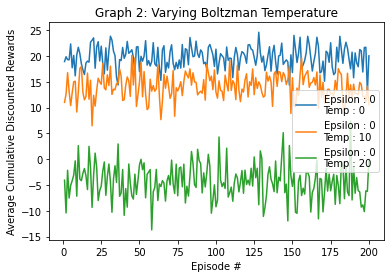

<Figure size 432x288 with 0 Axes>

In [31]:
# Graph 2
fig = plt.figure()
plt.title("Graph 2: Varying Boltzman Temperature")
plt.xlabel("Episode #")
plt.ylabel("Average Cumulative Discounted Rewards")
[Q,policy] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0,temperature=0)
print("Temperature : 0")
print("Q : " + str(Q))
print("Policy : " + str(policy))
print("\n")
[Q,policy] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0,temperature=10)
print("Temperature : 10")
print("Q : " + str(Q))
print("Policy : " + str(policy))
print("\n")
[Q,policy] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0,temperature=20)
print("Temperature : 20")
print("Q : " + str(Q))
print("Policy : " + str(policy))
print("\n")
plt.legend(loc='best')
plt.savefig('TestRLmaze_Graph2.png', bbox_inches='tight')
plt.show()
plt.close()
plt.cla()
plt.clf()


---
## Part II.III: Q-Learning Algorithm - Discussion
---
From Graph 1, we see that increasing the exploration probability reduces the average cumulative discounted rewards. We also observe that with increased exploration probability - exploitation of known best action reduces. This results in reducing discounted rewards, and reducing convergence of Q-values and policy. 

And from Graph 2, we see that increasing the boltzman temperature also reduces the average cumulative discounted rewards. Increasing boltzmann temperature also reduces exploitation of of known best action reduces. This results in reducing discounted rewards, and reducing convergence of Q-values and policy. 